In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as data
import matplotlib.pyplot as plt


In [153]:
import yfinance as yf
import datetime as dt
start = dt.datetime(2015,1,1)
end = dt.datetime(2025,7,1)
stock ="AAPL"
df = yf.download(stock,start,end,auto_adjust=False)

df.to_csv("stock_data.csv")
df = pd.read_csv("stock_data.csv")

df.rename(columns={"Price":"Date"},inplace=True)
df.drop(index=[0,1],inplace=True)
df=df.drop(["Adj Close","Date"],axis=1)
df = df.reset_index(drop=True)
#I had to apply this step for a certain reason
df = df.apply(pd.to_numeric, errors='coerce')
df

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
0,27.332500,27.860001,26.837500,27.847500,212818400
1,26.562500,27.162500,26.352501,27.072500,257142000
2,26.565001,26.857500,26.157499,26.635000,263188400
3,26.937500,27.049999,26.674999,26.799999,160423600
4,27.972500,28.037500,27.174999,27.307501,237458000
...,...,...,...,...,...
2633,200.300003,203.440002,200.199997,202.589996,54064000
2634,201.559998,203.669998,200.619995,201.449997,39525700
2635,201.000000,202.639999,199.460007,201.429993,50799100
2636,201.080002,203.220001,200.000000,201.889999,73188600


When i tried to plot this graph the first time, it didnt plot properly. Turned out that the values of the dataframe were of the tyoe "Object", so i had to convert them to numerical using a line mentioned above.

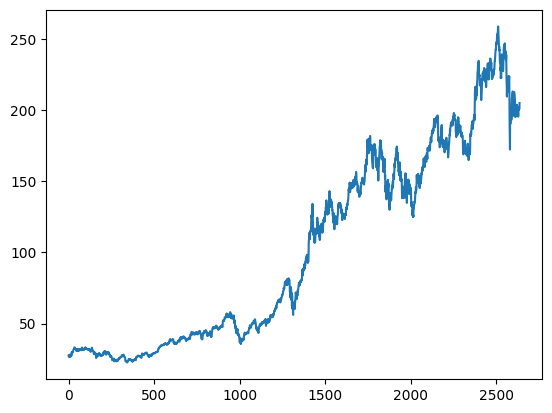

In [154]:

plt.plot(df.Close)

In [155]:
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()


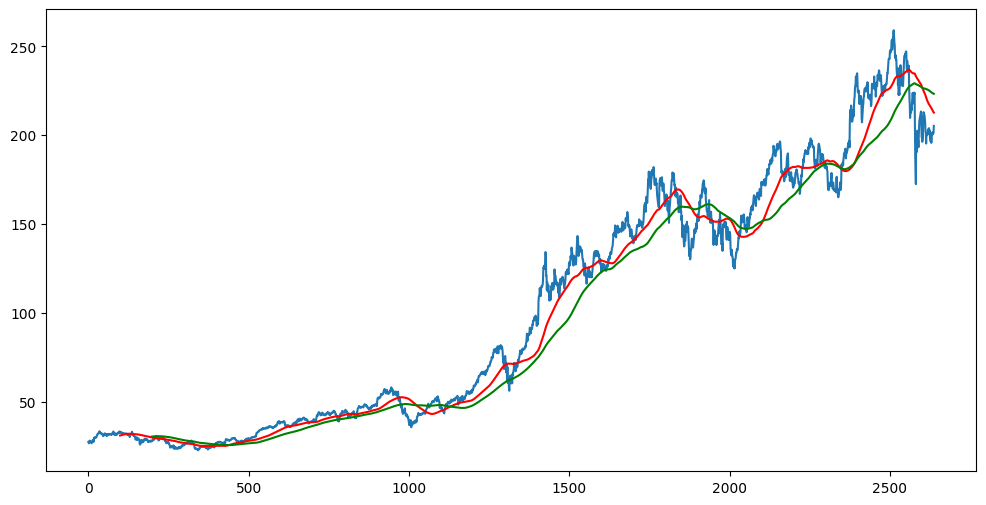

In [156]:

plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,"red")
plt.plot(ma200,"green")

In [157]:
data_training = pd.DataFrame(df["Close"][0:int(len(df)*0.7)])
data_testing = pd.DataFrame(df["Close"][int(len(df)*0.7):int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(1846, 1)
(792, 1)


In [158]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [159]:
data_training_array = scaler.fit_transform(data_training)
data_training_array = data_training_array.flatten()
len(data_training_array)


1846

In [160]:
X_train=[]
y_train=[] 

for i in range(100,len(data_training_array)):
    X_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i])

X_train,y_train = np.array(X_train),np.array(y_train)
X_train.shape

(1746, 100)

# Model

In [135]:
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential

In [138]:
model =Sequential()
model.add(LSTM(units=50,activation="relu",return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60,activation="relu",return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80,activation="relu",return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [139]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                       │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [140]:
model.compile(optimizer="adam",loss="mean_squared_error")
model.fit(X_train,y_train,epochs=50)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0764
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0078
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0080
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0047
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0051
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0053
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0039
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0044
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0039
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0040
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0036
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0039
Epoch 13/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0043
Epoch 14/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0035
Epoch 15/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0033
Epoc

In [141]:
model.save("stock_model.keras")

In [142]:
past_100_days = data_training.tail(100)

In [143]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)

In [144]:
final_df

,Close
0,175.080002
1,174.559998
2,179.449997
3,175.740005
4,174.330002
...,...
887,200.300003
888,201.559998
889,201.000000
890,201.080002


In [146]:
input_data = scaler.fit_transform(final_df)
input_data = input_data.flatten()
input_data.shape

(892,)

In [147]:
X_test = []
y_test=[]

for i in range(100,len(input_data)):
    X_test.append(input_data[i-100:i])
    y_test.append(input_data[i])

In [148]:
X_test,y_test = np.array(X_test),np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(792, 100)
(792,)


In [149]:
y_predicted = model.predict(X_test)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


In [162]:


y_predicted.shape


(792, 1)

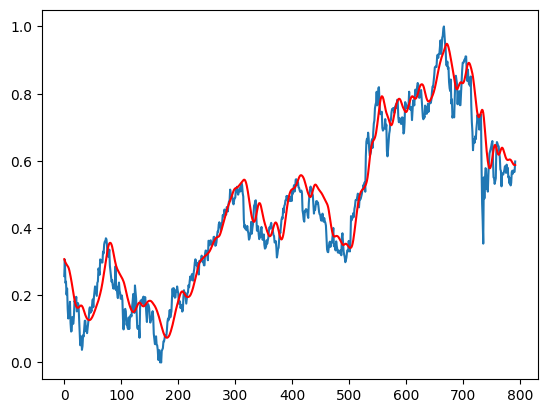

In [163]:
plt.plot(y_test)
plt.plot(y_predicted,"red")